In [1]:
from IPython.lib.deepreload import original_import
%load_ext autoreload
%autoreload 2

import ex4
import numpy as np
import matplotlib.pyplot as plt

### Example of a test script

In [ ]:
import modular_ex4
import imageio
import matplotlib.pyplot as plt

# ----------------- הגדרות ניסוי -----------------
VIDEO_FILE = "House.mp4"
STEP_SIZE = 16        # פרמטר לשליטה
BORDER_CUT = 15       # פרמטר לשליטה
ENABLE_ROT = True     # עם או בלי תיקון רוטציה
CONV_POINT = None     # אופציונלי: (x,y)
# CONV_POINT = (300, 250) # לדוגמה, אם אתה רוצה למרכז אובייקט

# ----------------- ביצוע ה-Pipeline -----------------

# 1. טעינה (פעם אחת)
raw_frames = modular_ex4.load_video_frames(VIDEO_FILE, downscale_factor=2)
h, w = raw_frames[0].shape[:2]

# 2. ייצוב (פעם אחת, לוקח זמן)
# מעבירים כאן את הפרמטרים כי הייצוב מחשב optical_flow
stable_frames = modular_ex4.stabilize_video(
    raw_frames,
    step_size=STEP_SIZE,
    border_cut=BORDER_CUT,
    enable_rotation=ENABLE_ROT
)

# 3. חישוב נתיב וגיאומטריה (מהיר)
# גם כאן מעבירים את הפרמטרים כי הוא מחשב שוב optical_flow על המיוצב
transforms = modular_ex4.compute_camera_path(
    stable_frames,
    step_size=STEP_SIZE,
    border_cut=BORDER_CUT,
    convergence_point=CONV_POINT
)

canvas_geo = modular_ex4.compute_canvas_geometry(transforms, h, w)

# 4. יצירת סרטון פנורמה (Multi-Perspective)
# כאן מייצרים פנורמות שונות על ידי שינוי ה-Anchor
print("Rendering multi-perspective movie...")
movie_frames = []
anchors = np.linspace(0, 1, num=20) # 20 פריימים לסרטון

for anchor in anchors:
    # שלב הרינדור לא צריך step_size כי אין בו חישוב תנועה, רק גזירה
    pan = modular_ex4.render_strip_panorama(stable_frames, transforms, canvas_geo, strip_anchor=anchor)

    # המרה ל-uint8 לשמירה בוידאו
    pan_uint8 = (np.clip(pan, 0, 1) * 255).astype(np.uint8)
    movie_frames.append(pan_uint8)

# שמירת התוצאה
imageio.mimsave("outputs/multi_perspective_output.mp4", movie_frames, fps=10)
print("Done! Video saved.")

In [ ]:
# שמירת תמונה אחת לדוגמה (מהמרכז)
simple_panorama = modular_ex4.render_strip_panorama(stable_frames, transforms, canvas_geo, strip_padding=1, interp_order=3,prefilter=True)
modular_ex4.save_panorama(simple_panorama, filename="center_view.jpg")

### lab

In [20]:
garden_video="Garden.mp4"
house_video="House.mp4"
kessaria_video="Kessaria.mp4"
cur_video = kessaria_video
frames = ex4.load_video_frames(cur_video, downscale_factor=2)
panorama_left = ex4.create_mosaic(frames, step_size=16, border_cut=15, strip_anchor=0.2)
panorama_mid = ex4.create_mosaic(frames, step_size=16, border_cut=15, strip_anchor=0.5)
panorama_right = ex4.create_mosaic(frames, step_size=16, border_cut=15, strip_anchor=0.8)
print(">>> done.")

Loading video from: Exercise Inputs/Kessaria.mp4
Loaded 270 RGB frames. Shape: (270, 360, 640, 3)
Step 1: Stabilizing Video (Anchor=0.2)...
Stabilizing video (Rotation Correction=True)...
Processed frame 0/270
Processed frame 10/270
Processed frame 20/270
Processed frame 30/270
Processed frame 40/270
Processed frame 50/270
Processed frame 60/270
Processed frame 70/270
Processed frame 80/270
Processed frame 90/270
Processed frame 100/270
Processed frame 110/270
Processed frame 120/270
Processed frame 130/270
Processed frame 140/270
Processed frame 150/270
Processed frame 160/270
Processed frame 170/270
Processed frame 180/270
Processed frame 190/270
Processed frame 200/270
Processed frame 210/270
Processed frame 220/270
Processed frame 230/270
Processed frame 240/270
Processed frame 250/270
Processed frame 260/270
Step 2: Calculating Canvas Limits...
Canvas Size: 1315x513
Step 3: Stitching strips from x=128...
Stitched 0/270
Stitched 20/270
Stitched 40/270
Stitched 60/270
Stitched 80/27

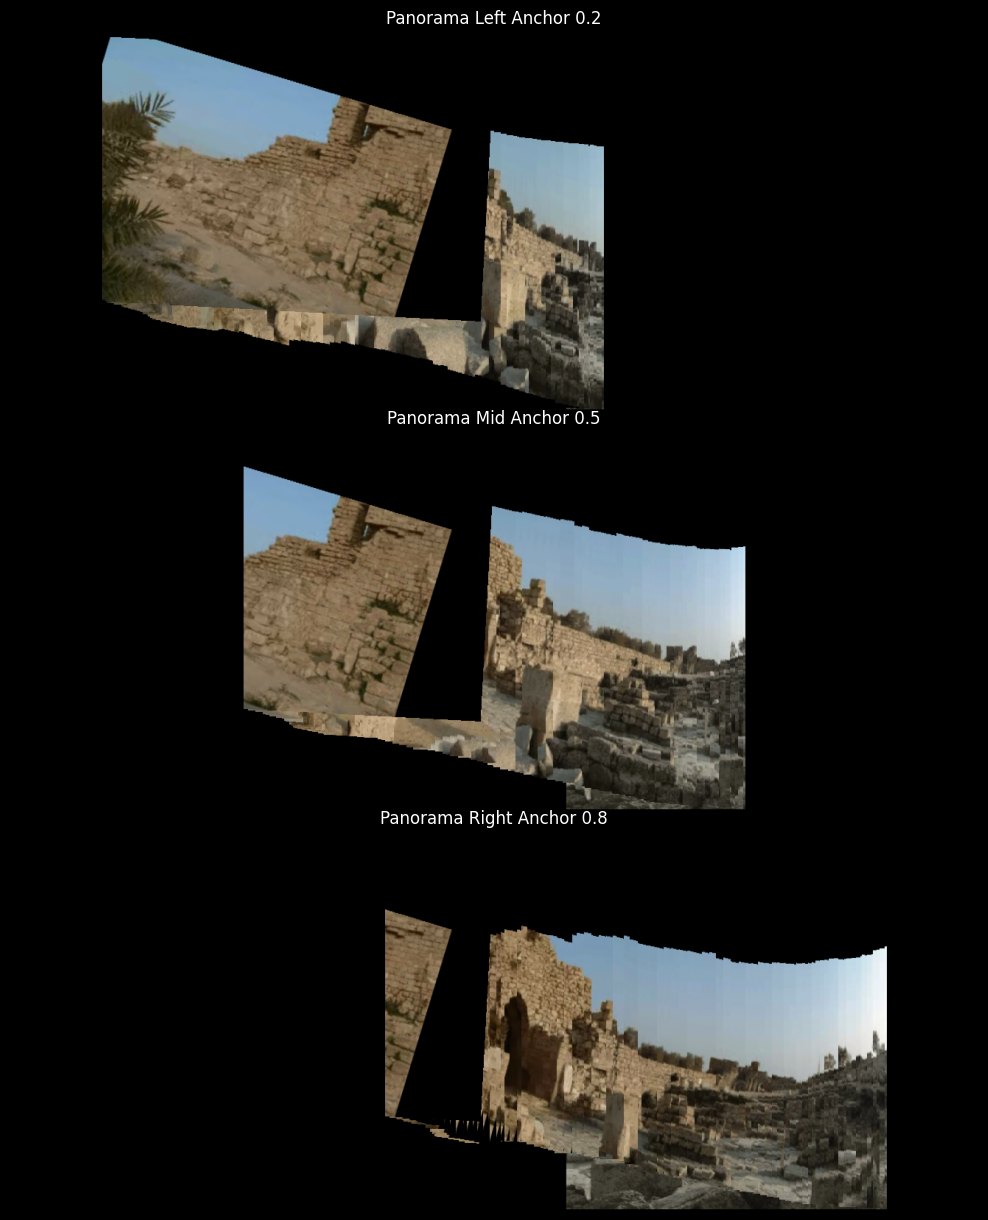

In [21]:
# show all 3 panoramas one line below the other
# with tight layout, no vertical padding between lines
plt.figure(figsize=(12, 12))
plt.subplot(3, 1, 1)
plt.imshow(panorama_left)
plt.title("Panorama Left Anchor 0.2")
plt.axis('off')
plt.subplot(3, 1, 2)
plt.imshow(panorama_mid)
plt.title("Panorama Mid Anchor 0.5")
plt.axis('off')
plt.subplot(3, 1, 3)
plt.imshow(panorama_right)
plt.title("Panorama Right Anchor 0.8")
plt.axis('off')
plt.tight_layout(pad=0.1)
plt.show()

# plt.figure(figsize=(12, 6))
# plt.imshow(panorama, cmap='gray')
# plt.title("Grayscale Panorama")
# plt.show()

In [4]:
ex4.save_panorama(panorama, filename="House_pan_right.png")

Saving panorama to: outputs/House_pan_right.png...
Success! Image saved.


### rotation graph

In [ ]:
# from skimage.color import rgb2gray  # וודא שיש לך את האימפורט הזה
#
# def plot_camera_path(frames, step_size, border_cut):
#     thetas = [0]
#     cumulative_theta = 0
#
#     print("Analyzing camera path...")
#     for i in range(len(frames) - 1):
#         # שליפת הפריימים
#         im1 = frames[i]
#         im2 = frames[i+1]
#
#         # --- התיקון: בדיקה והמרה לאפור אם צריך ---
#         if im1.ndim == 3:
#             im1 = rgb2gray(im1)
#         if im2.ndim == 3:
#             im2 = rgb2gray(im2)
#         # ------------------------------------------
#
#         # כעת im1 ו-im2 הם דו-ממדיים והפונקציה תעבוד
#         _, _, theta = ex4.optical_flow(im1, im2, step_size, border_cut)
#
#         cumulative_theta += theta
#         thetas.append(np.rad2deg(cumulative_theta))
#
#     plt.figure(figsize=(10, 4))
#     plt.plot(thetas, label='Camera Rotation (Degrees)')
#     plt.axhline(y=0, color='r', linestyle='--', alpha=0.5)
#     plt.title("Accumulated Rotation over Time")
#     plt.xlabel("Frame Index")
#     plt.ylabel("Angle (Degrees)")
#     plt.legend()
#     plt.grid(True)
#     plt.show()
#
#     print(f"Total Rotation: {thetas[-1]:.2f} degrees")
#     return thetas
#
# plot_camera_path(frames, step_size=16, border_cut=15)

### video of n panoramas

In [17]:
import imageio

# 2. רשימה לשמירת הפריימים של הסרטון החדש
movie_frames = ex4.dynamic_mosaic(frames, step_size=16, border_cut=15)

Creating panorama for anchor 0.10...
Step 1: Stabilizing Video (Anchor=0.1)...
Stabilizing video (Rotation Correction=True)...
Processed frame 0/435
Processed frame 10/435
Processed frame 20/435
Processed frame 30/435
Processed frame 40/435
Processed frame 50/435
Processed frame 60/435
Processed frame 70/435
Processed frame 80/435
Processed frame 90/435
Processed frame 100/435
Processed frame 110/435
Processed frame 120/435
Processed frame 130/435
Processed frame 140/435
Processed frame 150/435
Processed frame 160/435
Processed frame 170/435
Processed frame 180/435
Processed frame 190/435
Processed frame 200/435
Processed frame 210/435
Processed frame 220/435
Processed frame 230/435
Processed frame 240/435
Processed frame 250/435
Processed frame 260/435
Processed frame 270/435
Processed frame 280/435
Processed frame 290/435
Processed frame 300/435
Processed frame 310/435
Processed frame 320/435
Processed frame 330/435
Processed frame 340/435
Processed frame 350/435
Processed frame 360/

IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1800, 433) to (1808, 448) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


Movie saved!


In [19]:
imageio.mimsave('outputs/house_parallax_movie.mp4', movie_frames, fps=10) # fps נמוך כדי לראות את השינוי
print("Movie saved!")

IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1800, 433) to (1808, 448) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


Movie saved!
